In [ ]:
import os
import numpy as np
from PIL import Image

In [ ]:
PIC_DIR = '/content/original/'
IMAGES_COUNT = 150

In [ ]:
ORIG_WIDTH = 285
ORIG_HEIGHT = 213
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

In [ ]:
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

In [ ]:
images = []
for pic_file in (os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

In [ ]:
images = np.array(images) / 255
print(images.shape)

(150, 128, 128, 3)


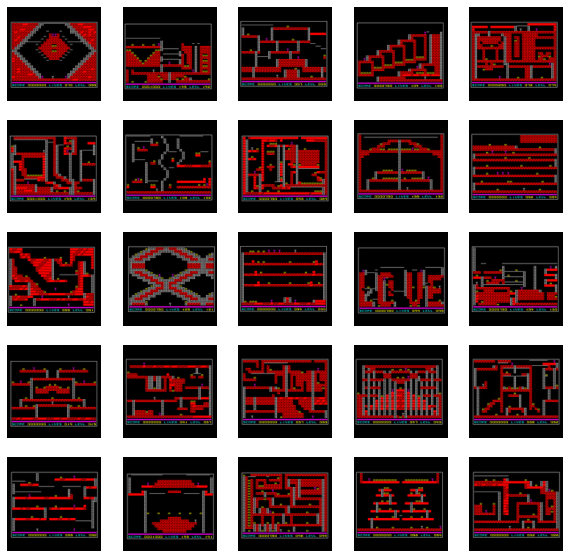

In [ ]:
from matplotlib import pyplot as plt
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
# from matplotlib import pyplot as plt
# plt.figure(1, figsize=(10, 10))
# for i in range(150):
#     plt.imshow(images[i])
#     plt.subplot(10, 10,i+1)
#     plt.axis('off')
# plt.show()

In [ ]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3

In [ ]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(200 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 200))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [ ]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50/2000: d_loss: 0.4471,  a_loss: 3.2584.  (1.0 sec)
100/2000: d_loss: 0.3293,  a_loss: 8.2270.  (1.0 sec)
150/2000: d_loss: 0.2195,  a_loss: 2.7603.  (1.0 sec)
200/2000: d_loss: 0.1740,  a_loss: 3.4696.  (1.0 sec)
250/2000: d_loss: 0.2540,  a_loss: 12.0593.  (1.0 sec)
300/2000: d_loss: 0.1235,  a_loss: 6.0019.  (1.1 sec)
350/2000: d_loss: 0.1721,  a_loss: 2.3374.  (1.1 sec)
400/2000: d_loss: 0.5639,  a_loss: 1.1831.  (1.0 sec)
450/2000: d_loss: 0.1382,  a_loss: 5.0560.  (1.0 sec)
500/2000: d_loss: 0.0014,  a_loss: 6.9215.  (1.1 sec)
550/2000: d_loss: 0.0240,  a_loss: 7.0143.  (1.0 sec)
600/2000: d_loss: 0.9414,  a_loss: 13.3178.  (1.0 sec)
650/2000: d_loss: 0.0794,  a_loss: 5.6092.  (1.1 sec)
700/2000: d_loss: 0.0138,  a_loss: 8.5199.  (1.1 sec)
750/2000: d_loss: 0.0053,  a_loss: 8.0061.  (1.0 sec)
800/2000: d_loss: 0.0251,  a_loss: 6.0907.  (1.1 sec)
850/2000: d_loss: 0.0799,  a_loss: 15.2307.  (1.1 sec)
900/2000: d_loss: 0.1441,  a_loss: 19.9511.  (1.1 sec)
950/2000: d_loss: 0.0763,

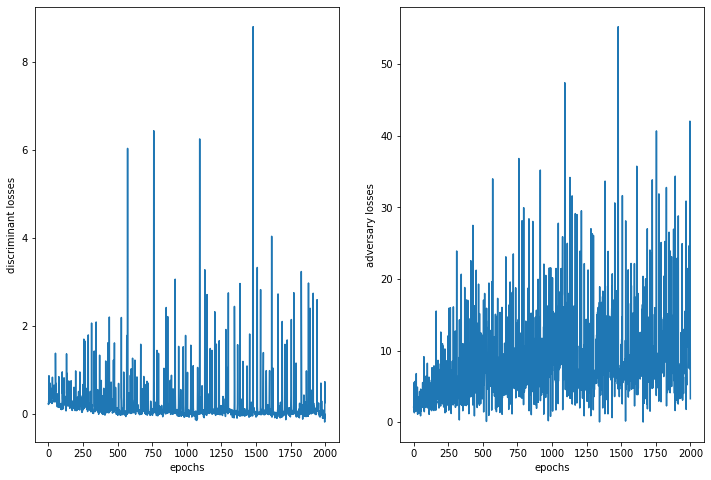

In [ ]:
import time
iters = 15000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/content/weights/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('/content/fakes/visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)